<a href="https://colab.research.google.com/github/Nehalokesh/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# **Load the Dataset**

In [ ]:
TRAIN_DIR ='/content/drive/MyDrive/Almabetter/Module 7/Capstone Project /train.zip (Unzipped Files)/train/'
TEST_DIR = '/content/drive/MyDrive/Almabetter/Module 7/Capstone Project /test.zip (Unzipped Files)/test/'


In [ ]:
def load_dataset(directory):
  image_paths = []
  labels = []

  for label in os.listdir(directory):
    for  filename in os.listdir(directory+label):
      image_path = os.path.join(directory, label, filename)
      image_paths.append(image_path)
      labels.append(label)

    print(label, "completed")

  return image_paths, labels

In [ ]:
## Convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
#shuffle the dataset 
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,/content/drive/MyDrive/Almabetter/Module 7/Cap...,happy
1,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry
2,/content/drive/MyDrive/Almabetter/Module 7/Cap...,happy
3,/content/drive/MyDrive/Almabetter/Module 7/Cap...,sad
4,/content/drive/MyDrive/Almabetter/Module 7/Cap...,neutral


In [ ]:
test = pd.DataFrame()
test['image'], test['label']=load_dataset(TEST_DIR)
test.head()


angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry
1,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry
2,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry
3,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry
4,/content/drive/MyDrive/Almabetter/Module 7/Cap...,angry


# **EXPLORATORY DATA ANALYSIS**


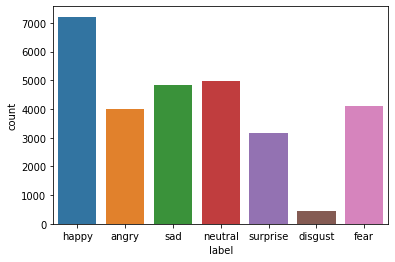

In [ ]:
sns.countplot(train['label'])

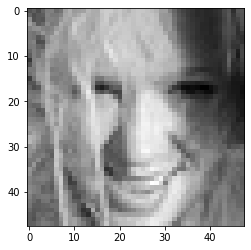

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap = 'gray');

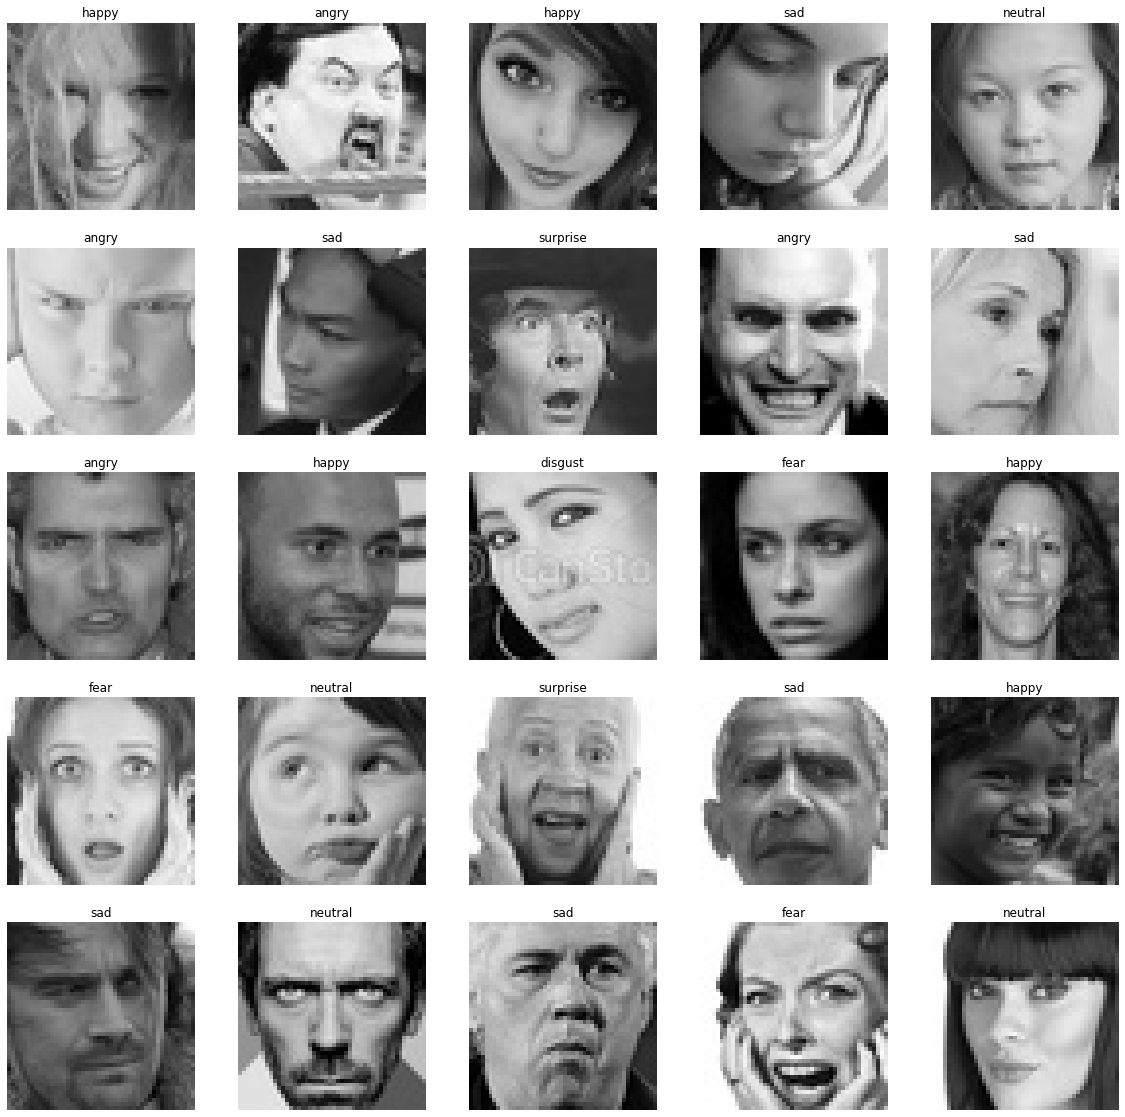

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')
  


Can you guess which images are related to which expressions?

This task is quite easy for a human, but it may be a bit challenging for a predictive algorithm because:

* The images have a low resolution
* The faces are not in the same position
* Some images have text written on them
* Some people hide part of their faces with their hands

# **Feature Extraction**

In [ ]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, grayscale = True)
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features), 48, 48, 1) 
  return features 

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28713 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
##conver label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

* Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

* It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

* The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).

In [ ]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
#config
input_shap = (48, 48, 1)
output_class = 7

# **Model creation**

In [ ]:
model = Sequential()
# convolutional layers

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


We define our CNN with the following global architecture:

* 4 convolutional layers
* 2 fully connected layers

The convolutional layers will extract relevant features from the images and the fully connected layers will focus on using these features to classify well our images. 

# **Train the Model**

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 24s 107ms/step - loss: 1.8101 - accuracy: 0.2520 - val_loss: 1.7884 - val_accuracy: 0.2542
Epoch 2/100
225/225 [==============================] - 24s 106ms/step - loss: 1.7640 - accuracy: 0.2701 - val_loss: 1.6844 - val_accuracy: 0.3295
Epoch 3/100
225/225 [==============================] - 24s 106ms/step - loss: 1.6586 - accuracy: 0.3354 - val_loss: 1.5090 - val_accuracy: 0.4100
Epoch 4/100
225/225 [==============================] - 25s 110ms/step - loss: 1.5412 - accuracy: 0.3976 - val_loss: 1.4430 - val_accuracy: 0.4312
Epoch 5/100
225/225 [==============================] - 24s 106ms/step - loss: 1.4734 - accuracy: 0.4304 - val_loss: 1.3615 - val_accuracy: 0.4799
Epoch 6/100
225/225 [==============================] - 24s 106ms/step - loss: 1.4324 - accuracy: 0.4439 - val_loss: 1.3174 - val_accuracy: 0.4939
Epoch 7/100
225/225 [==============================] - 25s 110ms/step - loss: 1.3932 - accuracy: 0.4638 - val_loss: 1.2772 -

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

# **plot the Results**

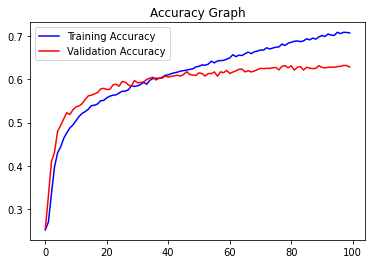

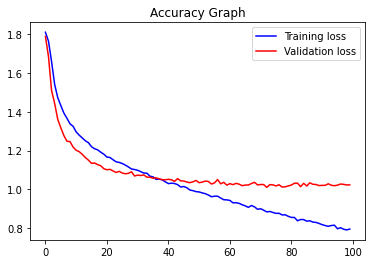

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Accuracy Graph')
plt.legend()

plt.show()

* The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

* We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

* We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

# **Test with image data**

Original Output: sad
Predicted Output: sad


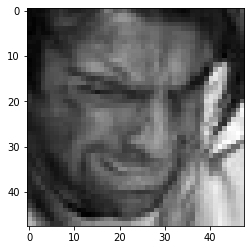

In [ ]:
image_index = random.randint(0, len(test))
print('Original Output:', test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print('Predicted Output:', prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

